# SECTION 0: IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import re
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import io

# SECTION 1: CORE COMPONENTS (PARSER, PREPROCESSING, MODEL)

In [2]:
# 1.1. Advanced CSV Parser
def parse_and_reconstruct_csv(filepath):
    """
    Parses a malformed CSV file where email content might span multiple lines.
    It reads the file line by line, identifies new email records, and merges
    any subsequent lines into the current record's message body.

    Args:
        filepath (str): The path to the malformed CSV file.

    Returns:
        pd.DataFrame: A clean, well-structured DataFrame.
    """
    print(f"\nParsing and reconstructing file: '{filepath}'...")

    try:
        # Read all lines using 'latin-1' encoding to prevent errors with special characters.
        with open(filepath, 'r', encoding='latin-1') as f:
            lines = f.readlines()
    except Exception as e:
        print(f"Error reading file: {e}")
        return pd.DataFrame()

    header = lines[0].strip()
    processed_records = []
    current_record_parts = []

    # Iterate through the file starting from the second line (skipping the header).
    for line in lines[1:]:
        line = line.strip()
        if not line:
            continue # Skip empty lines

        # A new record is identified if it starts with a number followed by a comma.
        if re.match(r'^\d+,', line):
            # If a record was being built, join its parts and save it.
            if current_record_parts:
                processed_records.append(' '.join(current_record_parts))

            # Start a new record with the current line.
            current_record_parts = [line]
        else:
            # If not a new record, it's a continuation of the previous one.
            if current_record_parts:
                current_record_parts.append(line)

    # Save the very last record after the loop finishes.
    if current_record_parts:
        processed_records.append(' '.join(current_record_parts))

    # Combine the header and all processed records into a clean CSV string.
    clean_csv_string = header + '\n' + '\n'.join(processed_records)

    # Read the clean string into a pandas DataFrame.
    reconstructed_df = pd.read_csv(io.StringIO(clean_csv_string))

    print(f"Reconstruction complete. Found {len(reconstructed_df)} records.")
    return reconstructed_df

In [3]:
# 1.2. Data Preprocessing Functions
def preprocess_dataframe(df):
    """
    Performs initial cleaning on the DataFrame.
    - Drops unnecessary columns ('Unnamed: 0', 'Message ID').
    - Removes duplicate rows.
    """
    df_copy = df.copy()
    cols_to_drop = ['Unnamed: 0', 'Message ID']
    if 'Spam/Han split' in df_copy.columns:
        cols_to_drop.append('Spam/Han split')
    df_copy = df_copy.drop(columns=cols_to_drop, errors='ignore')
    initial_rows = len(df_copy)
    df_copy.drop_duplicates(inplace=True)
    rows_dropped = initial_rows - len(df_copy)
    if rows_dropped > 0:
        print(f"   -> Dropped {rows_dropped} duplicate rows.")
    return df_copy

def combine_text_features(df):
    """
    Combines the 'Subject' and 'Message' columns into a single 'full_text' column.
    Handles potential missing values by filling them with empty strings.
    """
    df_copy = df.copy()
    df_copy['Subject'].fillna('', inplace=True)
    df_copy['Message'].fillna('', inplace=True)
    df_copy['full_text'] = df_copy['Subject'] + ' ' + df_copy['Message']
    return df_copy

def clean_text(text):
    """
    Cleans and tokenizes a single string of text.
    - Converts to lowercase.
    - Removes URLs, HTML tags, and any non-alphabetic characters.
    - Normalizes whitespace and splits the string into a list of words (tokens).
    """
    text = str(text).lower()
    text = re.sub(r'<.*?>|https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.split()

def run_preprocessing_pipeline(df_raw, dataset_name=""):
    """
    Runs the full preprocessing pipeline on a raw DataFrame.
    Combines cleaning, feature engineering, and label encoding.
    """
    print(f"\nPreprocessing the {dataset_name} set...")
    # Drop rows where the target label is missing before any processing.
    df_raw.dropna(subset=['Spam/Ham'], inplace=True)

    df_processed = preprocess_dataframe(df_raw)
    df_processed = combine_text_features(df_processed)
    df_processed['tokens'] = df_processed['full_text'].apply(clean_text)
    df_processed['label'] = df_processed['Spam/Ham'].map({'ham': 0, 'spam': 1})

    # Final check to ensure no rows have null labels after mapping.
    df_processed.dropna(subset=['label'], inplace=True)
    df_processed['label'] = df_processed['label'].astype(int)

    print(f"Preprocessing complete. Valid samples: {len(df_processed)}")
    return df_processed

In [4]:
# 1.3. Naive Bayes Classifier Class
class NaiveBayesClassifier:
    """
    A from-scratch implementation of the Multinomial Naive Bayes algorithm
    with Laplace (add-1) smoothing.
    """
    def __init__(self, alpha=1.0):
        """
        Initializes the classifier.
        Args:
            alpha (float): The smoothing parameter for Laplace smoothing.
        """
        self.alpha = alpha
        self.priors = {}
        self.likelihoods = {}
        self.vocabulary = set()

    def fit(self, X_train, y_train):
        """
        Trains the Naive Bayes model.
        - Calculates prior probabilities P(Class).
        - Builds the vocabulary from the training data.
        - Calculates likelihood probabilities P(Word | Class) with smoothing.
        """
        n_samples, classes = len(X_train), np.unique(y_train)

        # Calculate prior probabilities
        for c in classes:
            self.priors[c] = np.sum(y_train == c) / n_samples

        # Build vocabulary
        for tokens in X_train:
            self.vocabulary.update(tokens)
        vocab_size = len(self.vocabulary)

        # Count words per class
        word_counts = {c: defaultdict(int) for c in classes}
        total_word_counts = {c: 0 for c in classes}
        for tokens, c in zip(X_train, y_train):
            for token in tokens:
                word_counts[c][token] += 1
                total_word_counts[c] += 1

        # Calculate likelihoods with Laplace smoothing
        for c in classes:
            denominator = total_word_counts[c] + self.alpha * vocab_size
            self.likelihoods[c] = defaultdict(lambda: self.alpha / denominator)
            for word, count in word_counts[c].items():
                self.likelihoods[c][word] = (count + self.alpha) / denominator

    def predict(self, X_test):
        """
        Makes predictions for a collection of test samples.
        """
        return [self._predict_single(tokens) for tokens in X_test]

    def _predict_single(self, x_tokens):
        """
        Predicts the class for a single sample (list of tokens).
        Uses log-probabilities to prevent numerical underflow.
        """
        posteriors = {}
        for c in self.priors.keys():
            log_posterior = np.log(self.priors[c])
            for token in x_tokens:
                # defaultdict handles unseen words by providing a smoothed probability.
                log_posterior += np.log(self.likelihoods[c][token])
            posteriors[c] = log_posterior
        return max(posteriors, key=posteriors.get)

In [5]:
# 1.4. Evaluation and Reporting Function
def evaluate_and_report(dataset_name, y_true, y_pred):
    """
    Calculates, prints, and visualizes model performance metrics.
    Metrics: Accuracy, Precision, Recall, F1-score.
    Visualization: Confusion Matrix Heatmap.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print("\n" + "="*60)
    print(f"|   MODEL PERFORMANCE ON: {dataset_name.upper()}   |")
    print("="*60)
    print(f"- Accuracy:  {accuracy:.4f}")
    print(f"- Precision: {precision:.4f}")
    print(f"- Recall:    {recall:.4f}")
    print(f"- F1-score:  {f1_score:.4f}")

    cm = np.array([[tn, fp], [fn, tp]])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Ham', 'Predicted Spam'],
                yticklabels=['Actual Ham', 'Actual Spam'])
    plt.title(f'Confusion Matrix on {dataset_name}', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.show()

# SECTION 2: MAIN EXECUTION WORKFLOW

In [6]:
# 2.1. Load and Reconstruct Data
print("--- [STEP 1] LOADING AND RECONSTRUCTING DATA ---")
try:
    train_df_raw = parse_and_reconstruct_csv('train.csv')
    val_df_raw = parse_and_reconstruct_csv('val.csv')
    print("\nDisplaying the first 5 rows of the reconstructed training data:")
    display(train_df_raw.head())
except FileNotFoundError as e:
    print(f"Error: Data file not found. {e}")
    exit()

--- [STEP 1] LOADING AND RECONSTRUCTING DATA ---

Parsing and reconstructing file: 'train.csv'...
Reconstruction complete. Found 27284 records.

Parsing and reconstructing file: 'val.csv'...
Reconstruction complete. Found 3084 records.

Displaying the first 5 rows of the reconstructed training data:


,Unnamed: 0,Message ID,Subject,Message,Spam/Ham,split
0,0,0,christmas tree farm pictures,NaN,ham,0.038415
1,1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,0.696509
2,2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,0.587792
3,3,3,re : issue,fyi - see note below - already done . stella -...,ham,-0.055438
4,5,5,mcmullen gas for 11 / 99,"jackie , since the inlet to 3 river plant is s...",ham,-0.419658


In [7]:
# 2.2. Exploratory Data Analysis (EDA)
print("\n--- [STEP 2] EXPLORATORY DATA ANALYSIS (EDA) ---")
processed_train_df_eda = run_preprocessing_pipeline(train_df_raw, "EDA Training Set")


--- [STEP 2] EXPLORATORY DATA ANALYSIS (EDA) ---

Preprocessing the EDA Training Set set...


<ipython-input-3-2246265066>:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['Subject'].fillna('', inplace=True)
<ipython-input-3-2246265066>:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.met

Preprocessing complete. Valid samples: 27284


<ipython-input-8-2093543701>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plt.figure(figsize=(8, 6)); sns.countplot(x='Spam/Ham', data=train_df_raw.dropna(subset=['Spam/Ham']), palette='viridis')


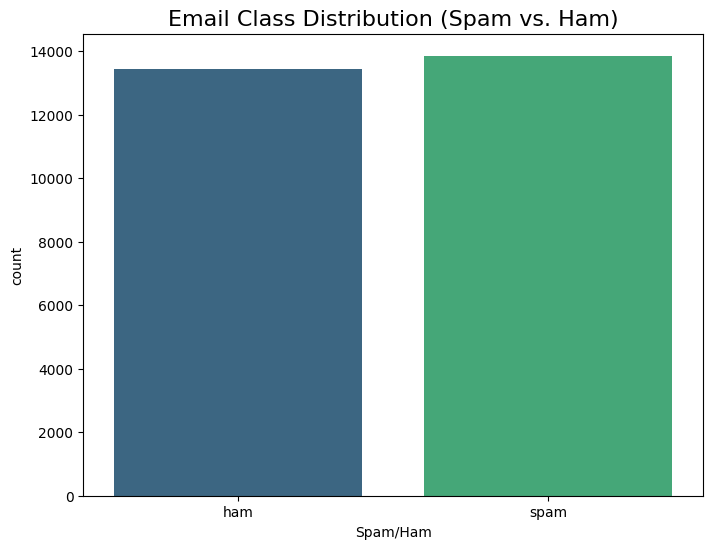

In [8]:
# Plot 1: Class Distribution
plt.figure(figsize=(8, 6)); sns.countplot(x='Spam/Ham', data=train_df_raw.dropna(subset=['Spam/Ham']), palette='viridis')
plt.title('Email Class Distribution (Spam vs. Ham)', fontsize=16); plt.show()

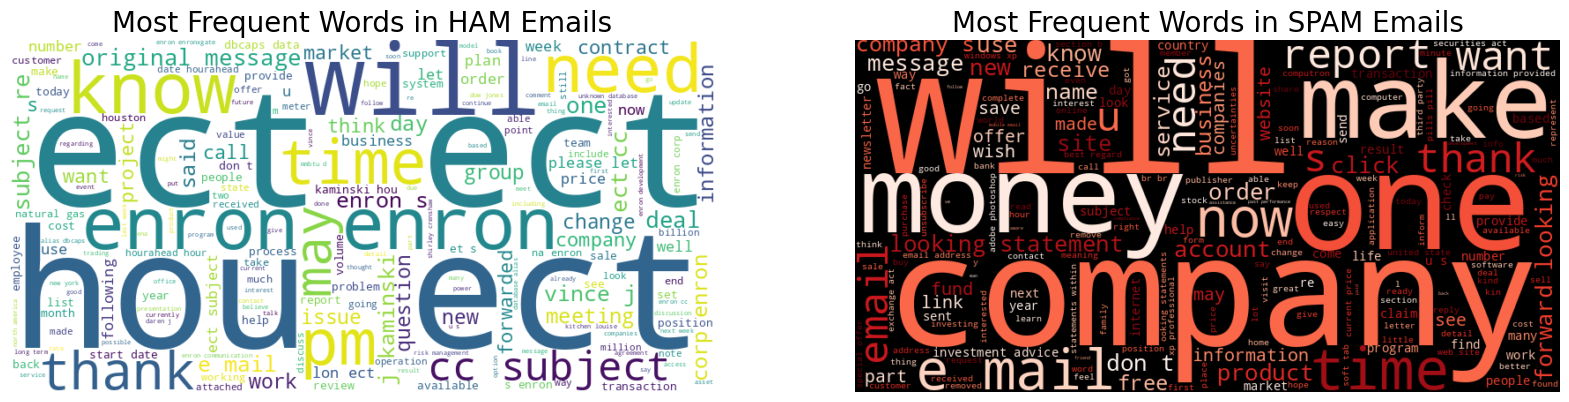

In [9]:
# Plot 2: Word Clouds
ham_tokens = processed_train_df_eda[processed_train_df_eda['label'] == 0]['tokens']
spam_tokens = processed_train_df_eda[processed_train_df_eda['label'] == 1]['tokens']
ham_text = " ".join([" ".join(tokens) for tokens in ham_tokens])
spam_text = " ".join([" ".join(tokens) for tokens in spam_tokens])
ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ham_text)
spam_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(spam_text)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(ham_wordcloud, interpolation='bilinear'); ax1.set_title('Most Frequent Words in HAM Emails', fontsize=20); ax1.axis('off')
ax2.imshow(spam_wordcloud, interpolation='bilinear'); ax2.set_title('Most Frequent Words in SPAM Emails', fontsize=20); ax2.axis('off')
plt.show()


--- [STEP 3] MODEL TRAINING & EVALUATION ---

Preprocessing the Training Set set...


<ipython-input-3-2246265066>:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['Subject'].fillna('', inplace=True)
<ipython-input-3-2246265066>:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.met

Preprocessing complete. Valid samples: 27284

Preprocessing the Validation Set set...


<ipython-input-3-2246265066>:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['Subject'].fillna('', inplace=True)
<ipython-input-3-2246265066>:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.met

Preprocessing complete. Valid samples: 3084

Model training complete!

|   MODEL PERFORMANCE ON: TRAIN SET (SEEN DATA)   |
- Accuracy:  0.9915
- Precision: 0.9921
- Recall:    0.9913
- F1-score:  0.9917


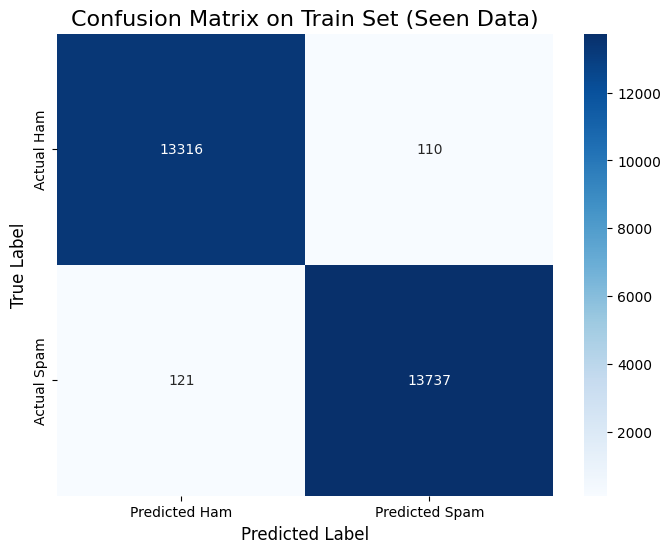


|   MODEL PERFORMANCE ON: VALIDATION SET (UNSEEN DATA)   |
- Accuracy:  0.9890
- Precision: 0.9885
- Recall:    0.9898
- F1-score:  0.9891


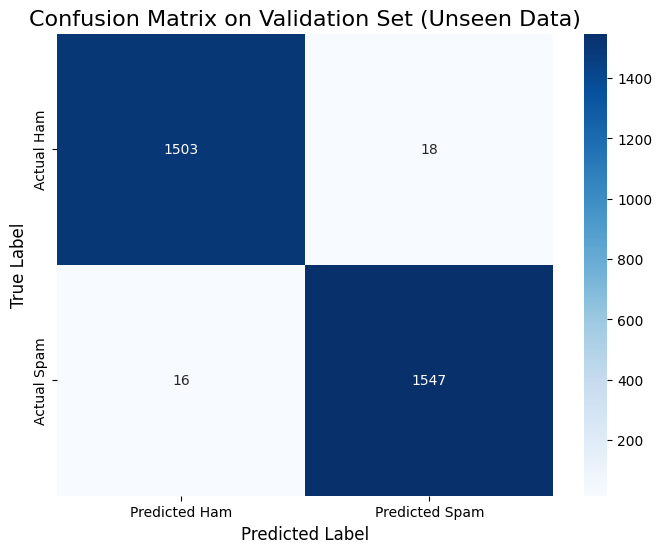

In [10]:
# 2.3. Model Training and Evaluation
print("\n--- [STEP 3] MODEL TRAINING & EVALUATION ---")
# Preprocess the datasets for training and validation
processed_train_df = run_preprocessing_pipeline(train_df_raw, "Training Set")
processed_val_df = run_preprocessing_pipeline(val_df_raw, "Validation Set")

# Prepare data splits
X_train, y_train = processed_train_df['tokens'], processed_train_df['label']
X_val, y_val = processed_val_df['tokens'], processed_val_df['label']

# Initialize and train the classifier
classifier = NaiveBayesClassifier(alpha=1.0)
classifier.fit(X_train, y_train)
print("\nModel training complete!")

# Evaluate on the training set (to check for underfitting)
y_train_pred = classifier.predict(X_train)
evaluate_and_report("Train Set (Seen Data)", y_train, y_train_pred)

# Evaluate on the validation set (to check for generalization)
y_val_pred = classifier.predict(X_val)
evaluate_and_report("Validation Set (Unseen Data)", y_val, y_val_pred)

In [11]:
# 2.4. Interactive Features
print("\n--- [STEP 4] INTERACTIVE FEATURES ---")


--- [STEP 4] INTERACTIVE FEATURES ---


In [12]:
# Feature 1: Predict a custom email
def interactive_email_predictor(classifier_model):
    """Allows the user to input a custom email and get a prediction."""
    print("\n" + "*"*25)
    print("FEATURE 1: CUSTOM EMAIL PREDICTOR")
    print("*"*25)
    print("The model will prompt you for an email subject and body.")
    print("Type 'quit' in the subject field to exit.")
    while True:
        try:
            subject = input("\nEnter email subject: ")
            if subject.lower() == 'quit':
                print("Exiting predictor."); break
            message = input("Enter email body: ")
            tokens = clean_text(subject + ' ' + message)
            prediction = classifier_model._predict_single(tokens)
            result = "Spam" if prediction == 1 else "Ham (Not Spam)"
            print(f"\n==> PREDICTION RESULT: This email is {result}")
        except (KeyboardInterrupt, EOFError):
            print("\nExiting predictor.")
            break

In [13]:
# Feature 2: Evaluate on any given CSV file
def evaluate_on_any_csv(classifier_model):
    """Asks the user for a CSV file path and evaluates the model on it."""
    print("\n" + "*"*25)
    print("FEATURE 2: EVALUATE ON A NEW CSV FILE")
    print("*"*25)
    try:
        filepath = input("Enter the path to the CSV file to evaluate (e.g., val.csv): ")
        if not filepath:
            print("No file path entered. Skipping this feature.")
            return

        df_to_test_raw = parse_and_reconstruct_csv(filepath)
        if df_to_test_raw.empty:
            print(f"Could not process file '{filepath}'.")
            return

        processed_df = run_preprocessing_pipeline(df_to_test_raw, filepath)
        X_test_data, y_true_data = processed_df['tokens'], processed_df['label']
        y_pred_data = classifier_model.predict(X_test_data)
        evaluate_and_report(filepath, y_true_data, y_pred_data)
    except FileNotFoundError:
        print(f"Error: File not found at '{filepath}'. Please check the path.")
    except Exception as e:
        print(f"An error occurred while processing the file: {e}")


*************************
FEATURE 1: CUSTOM EMAIL PREDICTOR
*************************
The model will prompt you for an email subject and body.
Type 'quit' in the subject field to exit.

Enter email subject: hello world
Enter email body: how are you today?

==> PREDICTION RESULT: This email is Spam

Enter email subject: Meeting tomorrow
Enter email body: Hi, reminder about our meeting at 10 AM tomorrow.

==> PREDICTION RESULT: This email is Ham (Not Spam)

Enter email subject: quit
Exiting predictor.

*************************
FEATURE 2: EVALUATE ON A NEW CSV FILE
*************************
Enter the path to the CSV file to evaluate (e.g., val.csv): val.csv

Parsing and reconstructing file: 'val.csv'...
Reconstruction complete. Found 3084 records.

Preprocessing the val.csv set...


<ipython-input-3-2246265066>:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['Subject'].fillna('', inplace=True)
<ipython-input-3-2246265066>:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.met

Preprocessing complete. Valid samples: 3084

|   MODEL PERFORMANCE ON: VAL.CSV   |
- Accuracy:  0.9890
- Precision: 0.9885
- Recall:    0.9898
- F1-score:  0.9891


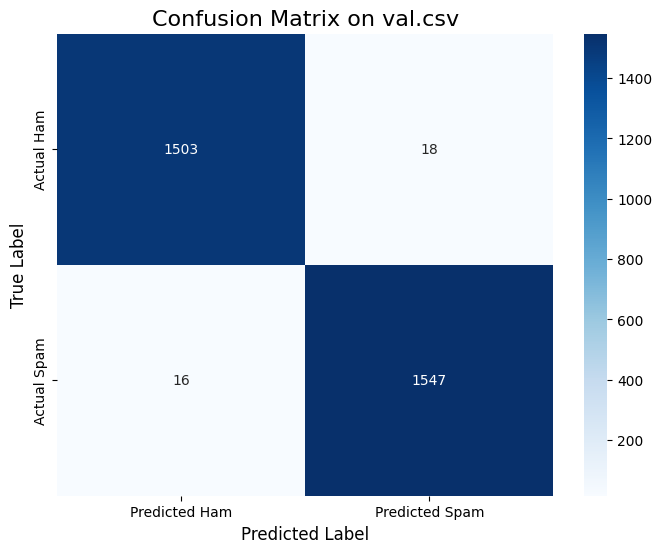

In [14]:
# --- RUN INTERACTIVE FEATURES ---
interactive_email_predictor(classifier)
evaluate_on_any_csv(classifier)